# Extracting and organizing the video files for training and validation

In [1]:
!pip -q install opencv-python-headless

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
#dependencies
import zipfile as zf
import shutil
from fnmatch import fnmatch
import cv2

In [3]:
#functions used in this section
def file_count(folder):
        l = []
        for root, dirs, files in os.walk(folder):
            for file in files:
                if fnmatch(file, "*.avi"):
                    l.append(file)
        return len(l)

In [147]:
#extracting the images
files = zf.ZipFile("videos.zip", 'r')
files.extractall('/notebooks')
files.close()

In [148]:
shutil.rmtree('training')
shutil.rmtree('testing')

In [149]:
#restructuring the data
dest = os.getcwd()
for folder in os.listdir('videos'):
    dir_to_move = os.path.join('videos', folder)
    shutil.move(dir_to_move, dest)
shutil.rmtree('videos')

In [150]:
print('Total number of training data: {0}'.format(file_count("training")))
print('Total number of testing data: {0}'.format(file_count("testing")))

Total number of training data: 117
Total number of testing data: 115


In [151]:
#initializing the minimum number of frame we want each training and testing video to be
NBFRAME = 5

In [152]:
#deleting any videos that does not have a minimum of 10 frames
from fnmatch import fnmatch
dsets = ['training', 'testing']
for folder in dsets:
    root = folder
    pattern = "*.avi"
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern):
                frame_number = cv2.VideoCapture(os.path.join(path,name)).get(cv2.CAP_PROP_FRAME_COUNT)
                if frame_number < NBFRAME:
                    os.remove(os.path.join(path,name))

In [7]:
print('Total number of training data: {0}'.format(file_count("training")))
print('Total number of testing data: {0}'.format(file_count("testing")))

Total number of training data: 117
Total number of testing data: 65


# Keras Video Generator

In [3]:
!pip -q install git+https://github.com/metal3d/keras-video-generators.git

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
#dependecies
import glob
import os
import tensorflow
from keras_video import VideoFrameGenerator

In [5]:
#use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('training/*')]
classes.sort()
classes

['flip', 'notflip']

In [6]:
# some global params
SIZE = (150, 270)
CHANNELS = 3
NBFRAME = 5
BS = 8

# pattern to get videos and classes
train_glob_pattern='training/{classname}/*.avi'
valid_glob_pattern='testing/{classname}/*.avi'


# for data augmentation
data_aug = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    rescale=1 / 255.0,
    classes=classes, 
    glob_pattern=train_glob_pattern,
    nb_frames=NBFRAME,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

valid = VideoFrameGenerator(
    rescale=1 / 255.0,
    classes=classes, 
    glob_pattern=valid_glob_pattern,
    nb_frames=NBFRAME,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 117 files for train
Total data: 2 classes for 65 files for train


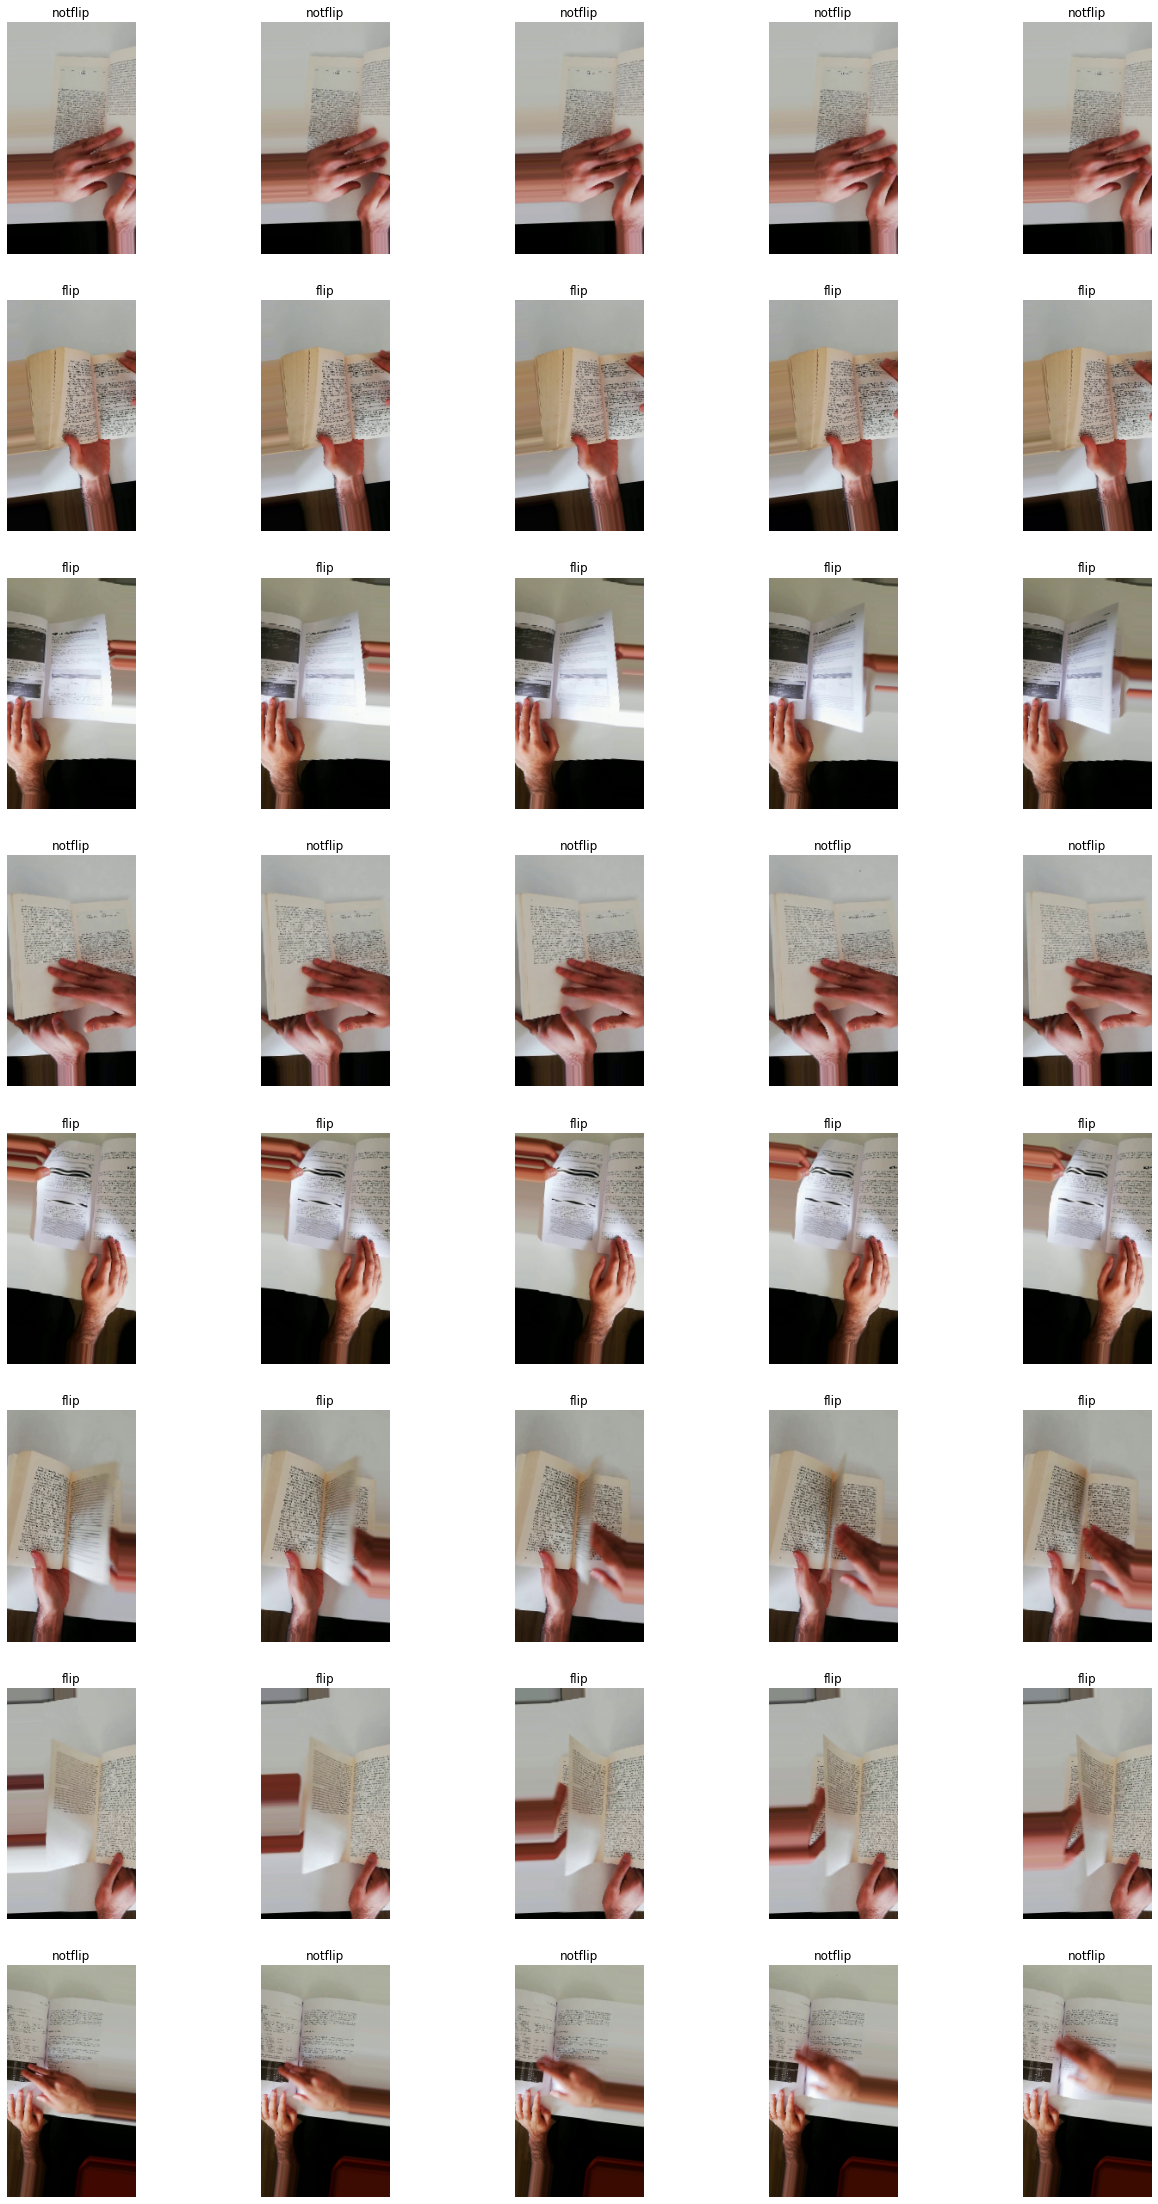

In [7]:
#sample batch
import keras_video.utils
keras_video.utils.show_sample(train)

# Pretrained CNN - LSTM Architecture

In [8]:
!pip -q install keras-tuner

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense
import tensorflow_addons as tfa
import keras_tuner as kt

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [10]:
#loading InceptionV3 with pre-trained weights and without classifiers
pre_trained_model = InceptionV3(input_shape = (150,270,3), weights='imagenet', include_top=False)

2022-02-09 17:48:23.796745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 17:48:23.824156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 17:48:23.824869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 17:48:23.828607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 17:48:23.829296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

87924736/87910968 [==============================] - 4s 0us/step


In [11]:
#set layers to be non-trainable for pre-trained model (freeze)
for layer in pre_trained_model.layers:
    layer.trainable = False

In [12]:
#defining the space for hyperparameter tuning
def build_model(hp):
    
    inputs = tensorflow.keras.Input(shape = (5, 150, 270, 3))
    cnn_out = tensorflow.keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)
    cnn = tensorflow.keras.Model(inputs=pre_trained_model.input, outputs=cnn_out)
    encoded_frames = TimeDistributed(cnn)(inputs)
    encoded_sequence = LSTM(
            #define hyperparameter
            units = hp.Int("lstm_units", min_value =32, max_value=512, step =32),
            activation='relu')(encoded_frames)

    hidden_layer_1 = Dense(
            #define hyperparmeter
            units = hp.Int("dense_layers_1", min_value=32, max_value=1024, step=32),
            activation = 'relu')(encoded_sequence)
    
    drop_out_1 = tensorflow.keras.layers.Dropout(rate=hp.Float('dropout_1',
                min_value=0.0,
                max_value=0.5,
                step=0.05))(hidden_layer_1)
    
    hidden_layer_2 = Dense(
            #define hyperparmeter
            units = hp.Int("dense_layers_2", min_value=32, max_value=512, step=32),
            activation = 'relu')(drop_out_1)
    
    drop_out_2 = tensorflow.keras.layers.Dropout(rate=hp.Float('dropout_2',
                min_value=0.0,
                max_value=0.5,
                step=0.05))(hidden_layer_2)
    
    outputs = Dense(2, activation='softmax')(drop_out_2)
    
    model = tensorflow.keras.Model([inputs], outputs)
    
    
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-5),
        loss = 'binary_crossentropy',
        metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average='macro')])
    
    return model

In [13]:
build_model(kt.HyperParameters())

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="hyperparameter",
    project_name="pre-trained-model",
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_layers_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dense_layers_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}


In [ ]:
tuner.search(train, epochs=500, validation_data=valid)

Trial 7 Complete [00h 39m 36s]
val_accuracy: 0.90625

Best val_accuracy So Far: 0.90625
Total elapsed time: 04h 38m 42s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
lstm_units        |32                |512               
dense_layers_1    |32                |32                
dropout_1         |0.5               |0.5               
dense_layers_2    |32                |32                
dropout_2         |0                 |0                 

Epoch 1/500
14/14 [==============================] - 12s 462ms/step - loss: 0.7081 - accuracy: 0.4018 - f1_score: 0.4014 - val_loss: 0.6953 - val_accuracy: 0.5000 - val_f1_score: 0.4459
Epoch 2/500
14/14 [==============================] - 5s 323ms/step - loss: 0.6966 - accuracy: 0.5000 - f1_score: 0.4986 - val_loss: 0.6956 - val_accuracy: 0.4375 - val_f1_score: 0.3455
Epoch 3/500
14/14 [==============================] - 5s 328ms/step - loss: 0.7194 - accuracy: 0.3839 - f1_score: 0.3839 - val_loss: 0.6960 

In [13]:
class myCallback(tensorflow.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_f1_score') is not None and logs.get('val_f1_score') > 0.90: # @KEEP
                print("\nReached 90% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [17]:
#defning the model based on the best parameter obtained in the hyperparameter search above

inputs = tensorflow.keras.Input(shape = (5, 150, 270, 3))
cnn_out = tensorflow.keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)
cnn = tensorflow.keras.Model(inputs=pre_trained_model.input, outputs=cnn_out)
encoded_frames = TimeDistributed(cnn)(inputs)
encoded_sequence = LSTM(512, activation='relu')(encoded_frames)
hidden_layer_1 = Dense(32 , activation = 'relu')(encoded_sequence)
drop_out_1 = tensorflow.keras.layers.Dropout(rate=0.5)(hidden_layer_1)
hidden_layer_2 = Dense(32, activation = 'relu')(drop_out_1)
outputs = Dense(2, activation='softmax')(hidden_layer_2)
model = tensorflow.keras.Model([inputs], outputs)
    
model.compile(
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'binary_crossentropy',
    metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average='macro')])
    

EPOCHS=1000

#using a callback - defined above to stop training when validation accuracy is greater than 90%
callbacks = [myCallback()]

history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks)

Epoch 1/1000
14/14 [==============================] - 12s 462ms/step - loss: 0.6971 - accuracy: 0.5536 - f1_score: 0.5530 - val_loss: 0.6913 - val_accuracy: 0.5625 - val_f1_score: 0.5039
Epoch 2/1000
14/14 [==============================] - 5s 323ms/step - loss: 0.6955 - accuracy: 0.5000 - f1_score: 0.4974 - val_loss: 0.6908 - val_accuracy: 0.6094 - val_f1_score: 0.6085
Epoch 3/1000
14/14 [==============================] - 4s 320ms/step - loss: 0.6921 - accuracy: 0.5714 - f1_score: 0.5625 - val_loss: 0.6904 - val_accuracy: 0.5781 - val_f1_score: 0.5730
Epoch 4/1000
14/14 [==============================] - 5s 327ms/step - loss: 0.6860 - accuracy: 0.5893 - f1_score: 0.5728 - val_loss: 0.6903 - val_accuracy: 0.5781 - val_f1_score: 0.5600
Epoch 5/1000
14/14 [==============================] - 5s 324ms/step - loss: 0.6875 - accuracy: 0.5625 - f1_score: 0.5495 - val_loss: 0.6905 - val_accuracy: 0.5312 - val_f1_score: 0.4805
Epoch 6/1000
14/14 [==============================] - 4s 318ms/step -

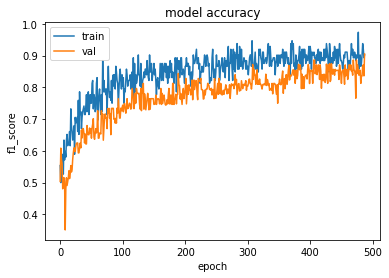

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

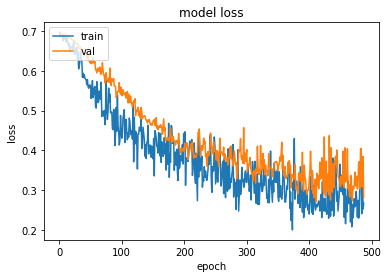

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

After 488 epochs, we got to a model accuracy of 90%. Custom model was defnitely better, as we were able to acheive 93% accuracy in 75 epochs. However, there are other things (listed below) that I could try to see if we can improve this version.

1. Instead the second-last layer of the pre-trained model, and use a layer well above that one as the feature extractor, because the second-last layer used here might be specialized to the task that it was trained for
2. Try a deeper model
3. Use a learning rate optimizer like the one used in previous task